# TensorFlow 2.0 alpha - Convolutional Variational Autoencoder
### Generate Images of Handwritten digits by Training a Variational Autoencoder 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the Dataset
#### MNIST Dataset - each image originally a vector of 784 integers - each between 0 - 255, representing pixel intensity
#### Model each pixel with a Bernoulli distribution in the model - statistically binarize the dataset

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# normalize the images to range of [0., 1.]

train_images /= 255.
test_images /= 255.

# binarization

train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.

test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [4]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

## Use tf.data - create batches and shuffle

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## Use tf.keras.Sequential - with 2 small ConvNets for generative and inference network
### Generative Network
* Generative Network takes latent encoding as Inputs - Outputs parameters for conditional distribution of Observation
* Use a unit Gaussian Prior for the latent variable

### Inference Network
* Defines posterior distribution - takes Observations as Input - Outputs parameters for conditional distribution of Latent Representation
* Model distribution as diagonal Gaussian
* Outputs the mean and log-variance parameters of a factorized Gaussian

### Reparameterization Trick
* During Optimization - sample from posterior distribution, by 1st sampling Unit Gaussian and multiplying by the standard deviation, and adding the mean
* Ensures Gradients pass through the sample to the Inference Network parameters

### Network Architecture
* 2 Convolutional layers - followed by Fully-connected Layer
* Generative Network, mirrors this architecture - using Fully-connected Layer, followed by 3 Conv Transpose layers

#### Common practice to avoid Batch Normalization when Training VAEs (additional stochasticity aggravates instability)

In [12]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28,28,1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
                tf.keras.layers.Flatten(),
                
                # no activation
                
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7,7,32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2,2),
                    padding='SAME',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2,2),
                    padding='SAME',
                    activation='relu'),
                
                # no activation
                
                tf.keras.layers.Conv2DTranspose(
                    filters=1,
                    kernel_size=3,
                    strides=(1,1),
                    padding='SAME'),
            ]
        )
        
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.laten_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

## Define Loss Function and Optimizer
#### VAEs train by maximizing the Evidence Lower Bound (ELBO) - on the marginal log-likelihood
#### In practice, optimize the single sample Monte Carlo estimate of this expectation

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

## Training
#### Start by iterating over dataset
* For each iteration pass the image to the Encoder - obtains a set of mean and log variance parameters of the approximate posterior
* Apply a Reparameterization Trick to the sample from above
* Pass Reparameterized samples to the Decoder - ontains logits of the generative distribution

## Generate Images
#### Sample a set of latent vectors from the unit Gaussian Prior distribution
* Generator will convert the latent sample to logits of the observation - for a generative distribution
* Plot the probabilities of Bernoulli distributions

In [17]:
epochs = 5
latent_dim = 50
num_examples_to_generate = 16

# keep the random vector constant for generation (prediction) so it is easier to see improvement

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, 
                                                      latent_dim])
model = CVAE(latent_dim)

In [18]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,...,0], cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 5, Test set ELBO: -101.97962188720703,time elapsed for current epoch 135.42551398277283


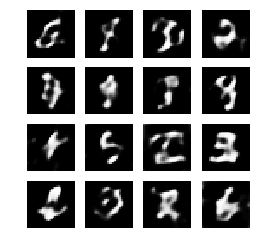

In [19]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {},'
              'time elapsed for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)

#### Generations would be improved with more Epochs - A GPU is recommended 
## Code to Display an Image using the Epoch number

(-0.5, 287.5, 287.5, -0.5)

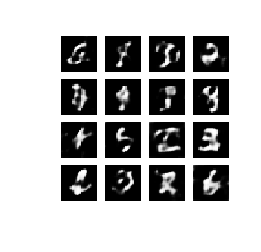

In [20]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epochs))
plt.axis('off')

## Generate a GIF - of all saved images

In [21]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
import IPython
if IPython.version_info >= (6,2,0, ''):
    display.Image(filename=anim_file)

#### If working in Colab - animation can be downloaded with the following code

In [22]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)